# Filter Warm Emission from 94 Å Observations

In [2]:
import os
import glob


import numpy as np
import pandas
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import hissw
from sunpy.map import Map,GenericMap
import h5py

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube

%matplotlib inline

In Warren et al. (2012) and Ugarte-Urra et al. (2014), a formula is given for computing the warm emission in the 94 Å channel of AIA in order to subtract it from the nominal AIA 94 Å data to get only the "hot" Fe XVIII data. The warm 94 Å intensity is given by,

$$
I_{94,\,\,warm} = A\sum^3_{i=0}c_ix^i
$$
where

$$
x = \frac{fI_{171} + (1-f)I_{193}}{B},
$$

$A = 0.39$, $B=116.32$, $f=0.31$, and $c=\{-7.19\times10^{-2},9.75\times10^{-1},9.79\times10^{-2},-2.81\times10^{-3}\}$. 

## Average Data
Time-average the intensity from the 171, 193, and 94 Å channels.

In [13]:
base_format = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{freq}/SDO_AIA/{channel}/map_t{time:06d}.fits'

In [14]:
aia = InstrumentSDOAIA([7.5e3,12.5e3]*u.s)
channels = [94,171,193]
frequencies = [250,750,2500,5000]
time_averaged_intensities = {freq:{channel:None for channel in channels} for freq in frequencies}

In [18]:
for i,t in enumerate(aia.observing_time):
    print(t)
    for channel in channels:
        tmp = Map(base_format.format(freq=250,channel=channel,time=i+750))
        if time_averaged_intensities[250][channel] is None:
            time_averaged_intensities[250][channel] = tmp
        else:
            time_averaged_intensities[250][channel].data += tmp.data
for channel in channels:
    time_averaged_intensities[250][channel].data = time_averaged_intensities[250][channel].data/aia.observing_time.shape[0]

7500.0 s
7510.0 s
7520.0 s
7530.0 s
7540.0 s
7550.0 s
7560.0 s
7570.0 s
7580.0 s
7590.0 s
7600.0 s
7610.0 s
7620.0 s
7630.0 s
7640.0 s
7650.0 s
7660.0 s
7670.0 s
7680.0 s
7690.0 s
7700.0 s
7710.0 s
7720.0 s
7730.0 s
7740.0 s
7750.0 s
7760.0 s
7770.0 s
7780.0 s
7790.0 s
7800.0 s
7810.0 s
7820.0 s
7830.0 s
7840.0 s
7850.0 s
7860.0 s
7870.0 s
7880.0 s
7890.0 s
7900.0 s
7910.0 s
7920.0 s
7930.0 s
7940.0 s
7950.0 s
7960.0 s
7970.0 s
7980.0 s
7990.0 s
8000.0 s
8010.0 s
8020.0 s
8030.0 s
8040.0 s
8050.0 s
8060.0 s
8070.0 s
8080.0 s
8090.0 s
8100.0 s
8110.0 s
8120.0 s
8130.0 s
8140.0 s
8150.0 s
8160.0 s
8170.0 s
8180.0 s
8190.0 s
8200.0 s
8210.0 s
8220.0 s
8230.0 s
8240.0 s
8250.0 s
8260.0 s
8270.0 s
8280.0 s
8290.0 s
8300.0 s
8310.0 s
8320.0 s
8330.0 s
8340.0 s
8350.0 s
8360.0 s
8370.0 s
8380.0 s
8390.0 s
8400.0 s
8410.0 s
8420.0 s
8430.0 s
8440.0 s
8450.0 s
8460.0 s
8470.0 s
8480.0 s
8490.0 s
8500.0 s
8510.0 s
8520.0 s
8530.0 s
8540.0 s
8550.0 s
8560.0 s
8570.0 s
8580.0 s
8590.0 s
8600.0 s
8

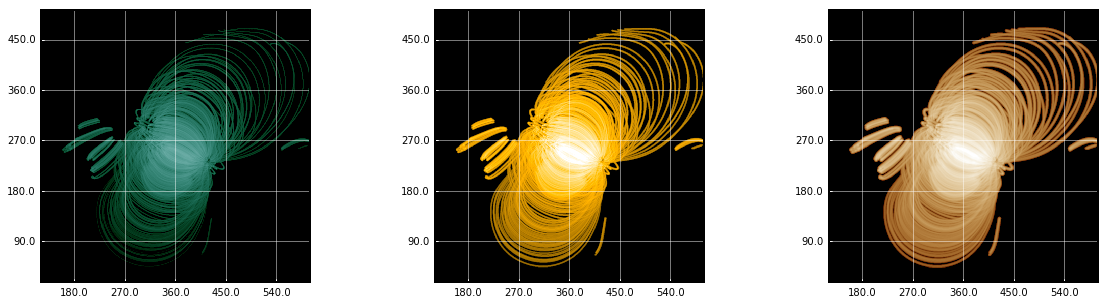

In [29]:
fig = plt.figure(figsize=(20,5))
for i,channel in enumerate(channels):
    tmp = time_averaged_intensities[250][channel]
    ax = fig.add_subplot(1,3,i+1,projection=tmp)
    tmp.plot(annotate=False,axes=ax,title=False,
             norm = matplotlib.colors.SymLogNorm(1e-5,vmin=1e-3,vmax=5e3))

## Apply Correction

Set constants used in warm filtering correction.

In [56]:
f = 0.31
A = 0.39
B = 116.32
ci = np.array([-7.19e-2,9.75e-1,9.79e-2,-2.81e-3])

Calculate warm emission map.

In [57]:
warm_94 = A*np.sum([c*((f*time_averaged_intensities[250][171].data + (1-f)*time_averaged_intensities[250][193].data)/B)**i 
                    for i,c in enumerate(ci)],axis=0)
warm_94 = np.where(warm_94<0,0,warm_94)
hot_94 = Map(time_averaged_intensities[250][94].data - warm_94,
             time_averaged_intensities[250][94].meta)
warm_94 = Map(warm_94,time_averaged_intensities[250][94].meta)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


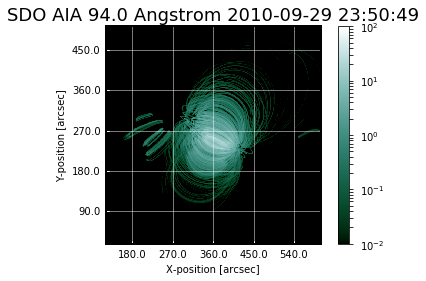

In [58]:
time_averaged_intensities[250][94].peek(norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1e-2,vmax=1e2))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


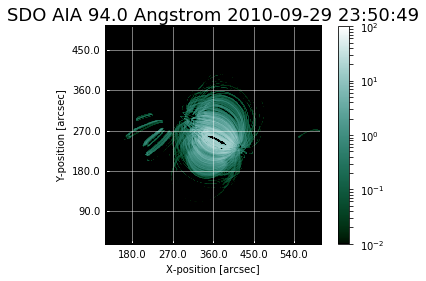

In [59]:
warm_94.peek(norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1e-2,vmax=1e2))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


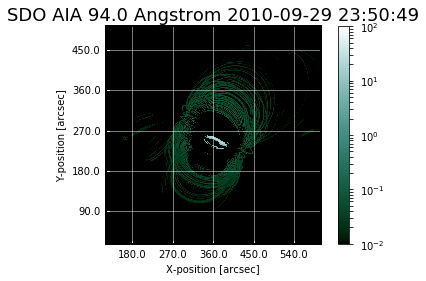

In [60]:
hot_94.peek(norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1e-2,vmax=1e2))